### Pytorch task4 
The following content is from torch documentation
因上一个task里面完成了Multi layer的部分 这个部分自行看文档

#### Transfer Learning

In [1]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

plt.ion() #interative mode

In [2]:
# Load data and make data iterable
# Transforms are common image transformations.
data_transforms = {
    'train' : transforms.Compose([
        # Crop the given PIL Image to random size and aspect ratio
        transforms.RandomResizedCrop(224),
        # Horizontally flip the given PIL Image randomly with a given probability.
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
    ]),
    'val' : transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
    ])
}

data_dir = 'hymenoptera_data'

image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                 data_transforms[x])
                 for x in ['train', 'val']}                                      

dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size = 4,
                                             shuffle=True, num_workers=4)
               for x in ['train', 'val']}

dataset_sizes = {x:len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

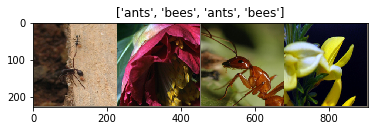

In [3]:
# understand data augmentation by visualizing a few training images
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated
    
# get batch of training data 
inputs, classes = next(iter(dataloaders['train']))

# make a grid from batch 方格
out = torchvision.utils.make_grid(inputs)
    
imshow(out, title=[class_names[x] for x in classes])

In [4]:
# Create Model and instantiate\
# Finetunning

model_ft = models.resnet18(pretrained=True)
#

num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 2)
        
model_ft = model_ft.to(device)

In [5]:
# Instantiate loss class 
criterion = nn.CrossEntropyLoss()

# Instantiate optimizer
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay Learning Rate by a factor of 0.1 every 7 epochs 
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [6]:
# template in training model
#for input, target in dataset:
#    optimizer.zero_grad()
#    output = model(input)
#    loss = loss_fn(output, target)
#    loss.backward()
#    optimizer.step()

In [9]:
# Training the model
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()
    
    best_model_wtf = copy.deepcopy(model.state_dict())
    
    best_acc = 0.0
    
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        
        for phase in ['train', 'val']:
            if phase == 'train':  # training model
                #torch.optim.lr_scheduler provides several methods to adjust the learning rate based on the number of epochs. 
                scheduler.step()
                model.train()
                
            else:                # evaluation mode
                model.eval()
                
            running_loss = 0.0
            running_corrects = 0
            
            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                # zero the parameter gradient 
                optimizer.zero_grad()
                
                # forward 
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    
                    if phase == 'train':
                        loss.backward()
                        
                        #This is a simplified version supported by 
                        #most optimizers. The function can be called
                        #once the gradients are computed using e.g. 
                        #backward().
                        
    
                        optimizer.step()
        
                #statistics 
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                    phase, epoch_loss, epoch_acc))
            
            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                

            print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model                     
                


In [10]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------
train Loss: 0.4864 Acc: 0.7623

val Loss: 0.2576 Acc: 0.8954

Epoch 1/24
----------
train Loss: 0.4537 Acc: 0.8115

val Loss: 0.2020 Acc: 0.9346

Epoch 2/24
----------
train Loss: 0.5365 Acc: 0.7910

val Loss: 0.3277 Acc: 0.8824

Epoch 3/24
----------
train Loss: 0.5836 Acc: 0.8033

val Loss: 1.4444 Acc: 0.7451

Epoch 4/24
----------
train Loss: 0.6704 Acc: 0.7664

val Loss: 0.4231 Acc: 0.8431

Epoch 5/24
----------
train Loss: 0.4498 Acc: 0.8156

val Loss: 0.3418 Acc: 0.8889

Epoch 6/24
----------
train Loss: 0.4040 Acc: 0.8197

val Loss: 0.3123 Acc: 0.9020

Epoch 7/24
----------
train Loss: 0.3413 Acc: 0.8525

val Loss: 0.3213 Acc: 0.8758

Epoch 8/24
----------
train Loss: 0.2804 Acc: 0.8689

val Loss: 0.2910 Acc: 0.9020

Epoch 9/24
----------
train Loss: 0.3247 Acc: 0.8607

val Loss: 0.2926 Acc: 0.9020

Epoch 10/24
----------
train Loss: 0.3021 Acc: 0.8730

val Loss: 0.2578 Acc: 0.9281

Epoch 11/24
----------
train Loss: 0.2731 Acc: 0.8893

val Loss: 0.2663 Acc

In [11]:
model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

In [12]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.6394 Acc: 0.6557

val Loss: 0.2129 Acc: 0.9412

Epoch 1/24
----------
train Loss: 0.5026 Acc: 0.7828

val Loss: 0.2199 Acc: 0.9150

Epoch 2/24
----------
train Loss: 0.4687 Acc: 0.8115

val Loss: 0.1766 Acc: 0.9346

Epoch 3/24
----------
train Loss: 0.4442 Acc: 0.8197

val Loss: 0.1632 Acc: 0.9542

Epoch 4/24
----------
train Loss: 0.4419 Acc: 0.8361

val Loss: 0.1818 Acc: 0.9477

Epoch 5/24
----------
train Loss: 0.2715 Acc: 0.9098

val Loss: 0.1592 Acc: 0.9477

Epoch 6/24
----------
train Loss: 0.3089 Acc: 0.8770

val Loss: 0.1709 Acc: 0.9542

Epoch 7/24
----------
train Loss: 0.3492 Acc: 0.8443

val Loss: 0.1845 Acc: 0.9477

Epoch 8/24
----------
train Loss: 0.3757 Acc: 0.8115

val Loss: 0.1847 Acc: 0.9477

Epoch 9/24
----------
train Loss: 0.4067 Acc: 0.8033

val Loss: 0.1912 Acc: 0.9477

Epoch 10/24
----------
train Loss: 0.2964 Acc: 0.8934

val Loss: 0.1751 Acc: 0.9412

Epoch 11/24
----------
train Loss: 0.3036 Acc: 0.8525

val Loss: 0.1669 Acc